In [1]:
import pandas as pd
import numpy as np
import re
import random
import seaborn as sns
import matplotlib as plt
import matplotlib.pyplot as plt

## Data cleaning

In [2]:
data = pd.read_csv('flight_info.csv')
data.head()

,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members
0,2022/9/1,6959,8L8L9919/8L9920,昆,320,昆芒昆,2022/9/1 6:40,2022/9/1 9:32,2:07,4
1,2022/9/1,5449,8L8L9865/8L9866,昆,738,昆济昆,2022/9/1 6:42,2022/9/1 14:09,6:25,4
2,2022/9/1,6016,8L8L9863/8L9864,昆,738,昆盐昆,2022/9/1 6:46,2022/9/1 13:42,5:55,4
3,2022/9/1,5407,8L8L9859/8L9860,昆,738,昆合昆,2022/9/1 6:49,2022/9/1 13:00,5:02,4
4,2022/9/1,5289/5825,8L8L9927N/8L9928/8L9953/8L9954,昆,737,昆保昆腾昆,2022/9/1 6:55,2022/9/1 21:38,3:47,4


In [3]:
# collect the circle flight range
def filter_and_create_new_df(dataframe, column_name):
    filtered_rows = []

    for _, row in dataframe.iterrows():
        cell_value = row[column_name]
        chinese_words = re.findall('[\u4e00-\u9fff]', str(cell_value))  #recognize the chinese word
        
        if len(chinese_words) >= 2 and chinese_words[0] == chinese_words[-1]:
            filtered_rows.append(1)
        else:
            filtered_rows.append(0)

    new_dataframe = dataframe.copy()
    new_dataframe['Result'] = filtered_rows

    return new_dataframe[new_dataframe['Result'] == 1].reset_index(drop=True)

# 
df1 = filter_and_create_new_df(data, 'Range')
df1.head()


,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result
0,2022/9/1,6959,8L8L9919/8L9920,昆,320,昆芒昆,2022/9/1 6:40,2022/9/1 9:32,2:07,4,1
1,2022/9/1,5449,8L8L9865/8L9866,昆,738,昆济昆,2022/9/1 6:42,2022/9/1 14:09,6:25,4,1
2,2022/9/1,6016,8L8L9863/8L9864,昆,738,昆盐昆,2022/9/1 6:46,2022/9/1 13:42,5:55,4,1
3,2022/9/1,5407,8L8L9859/8L9860,昆,738,昆合昆,2022/9/1 6:49,2022/9/1 13:00,5:02,4,1
4,2022/9/1,5289/5825,8L8L9927N/8L9928/8L9953/8L9954,昆,737,昆保昆腾昆,2022/9/1 6:55,2022/9/1 21:38,3:47,4,1


In [4]:
# collect the non-circle flight range
def filter_and_create_new_df(dataframe, column_name):
    filtered_rows = []

    for _, row in dataframe.iterrows():
        cell_value = row[column_name]
        chinese_words = re.findall('[\u4e00-\u9fff]', str(cell_value))  
        
        if len(chinese_words) >= 2 and chinese_words[0] == chinese_words[-1]:
            filtered_rows.append(1)
        else:
            filtered_rows.append(0)

    new_dataframe = dataframe.copy()
    new_dataframe['Result'] = filtered_rows

    return new_dataframe[new_dataframe['Result'] == 0].reset_index(drop=True)

# 
df2 = filter_and_create_new_df(data, 'Range')
df2.head()


,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result
0,2022/9/1,8732,8L8L9971,昆,320,昆琼,2022/9/1 7:05,2022/9/1 8:58,1:53,4,0
1,2022/9/1,6959,8L8L9904,昆,320,昆纳,2022/9/1 14:03,2022/9/1 15:06,1:03,4,0
2,2022/9/1,6943,8L8L9903,昆,320,纳昆,2022/9/1 15:08,2022/9/1 16:08,1:01,4,0
3,2022/9/1,1361,8L8L9973,昆,3NE,昆琼,2022/9/1 20:16,2022/9/1 21:58,1:42,4,0
4,2022/9/2,1563,8L8L9903/8L9953/8L9954,昆,737,纳昆腾昆,2022/9/2 15:14,2022/9/2 23:50,3:16,4,0


In [5]:
# merge flight range as a circle range
def merge_rows_with_matching_chars(dataframe, text_column, time_column, num_column):
    merged_dataframe = pd.DataFrame(columns=dataframe.columns)  # Create an empty DataFrame with the same columns
    
    prev_row = None  # Store the previous row data
    
    for index, row in dataframe.iterrows():
        if prev_row is None:
            prev_row = row
        else:
            curr_range = str(row[text_column])
            prev_range = str(prev_row[text_column])
            
            if curr_range[0] == prev_range[-1] and curr_range[-1] == prev_range[0]:
                merged_row = prev_row.copy()  # Copy the previous row data
                
                # Merge row data
                merged_row[text_column] = prev_range + curr_range # merge range
                merged_row[time_column] = add_time(prev_row[time_column], row[time_column]) #merge flight period
                merged_row[num_column] =  (prev_row[num_column] + row[num_column])/2 # merge employee number
                merged_row['Actual Takeoff2'] = row['Actual Takeoff']
                merged_row['Actual Landing2'] = row['Actual Landing']
                merged_dataframe = pd.concat([merged_dataframe, pd.DataFrame(merged_row).transpose()], ignore_index=True)  # Concatenate the merged row to the new DataFrame
                
                prev_row = None  # Reset previous row data to None
            else:
                merged_dataframe = pd.concat([merged_dataframe, pd.DataFrame(prev_row).transpose()], ignore_index=True)  # Concatenate the previous row to the new DataFrame
                prev_row = row
                

    # Add the last row to the new DataFrame
    if prev_row is not None:
        merged_dataframe = pd.concat([merged_dataframe, pd.DataFrame(prev_row).transpose()], ignore_index=True)
    
    return merged_dataframe

    


def add_time(time1, time2):
    # Perform time addition
    # Assuming time format is "H:MM"
    hours1, minutes1 = map(int, time1.split(':'))
    hours2, minutes2 = map(int, time2.split(':'))
    
    total_minutes = (hours1 + hours2) * 60 + (minutes1 + minutes2)
    hours = total_minutes // 60
    minutes = total_minutes % 60
    
    return f"{hours}:{minutes:02d}"


# Assuming 'df' is your original DataFrame
merged_df1 = merge_rows_with_matching_chars(df2, 'Range', 'Flight Period','Number of Crew Members')
merged_df1



,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result,Actual Takeoff2,Actual Landing2
0,2022/9/1,8732,8L8L9971,昆,320,昆琼,2022/9/1 7:05,2022/9/1 8:58,1:53,4,0,NaN,NaN
1,2022/9/1,6959,8L8L9904,昆,320,昆纳纳昆,2022/9/1 14:03,2022/9/1 15:06,2:04,4.0,0,2022/9/1 15:08,2022/9/1 16:08
2,2022/9/1,1361,8L8L9973,昆,3NE,昆琼,2022/9/1 20:16,2022/9/1 21:58,1:42,4,0,NaN,NaN
3,2022/9/2,1563,8L8L9903/8L9953/8L9954,昆,737,纳昆腾昆昆纳,2022/9/2 15:14,2022/9/2 23:50,4:19,4.0,0,2022/9/2 15:36,2022/9/2 16:39
4,2022/9/2,8445,8L8L9610,昆,320,纳丽,2022/9/2 17:55,2022/9/2 19:07,1:17,4,0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,2022/9/30,5732,8L8L9628,昆,738,昆蜀,2022/9/30 14:58,2022/9/30 16:14,1:16,4,0,NaN,NaN
83,2022/9/30,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/30 15:39,2022/9/30 16:32,1:57,4.0,0,2022/9/30 15:47,2022/9/30 16:51
84,2022/9/30,6015,8L8L9543,昆,738,蜀昆,2022/9/30 18:19,2022/9/30 19:43,1:25,4,0,NaN,NaN
85,2022/9/30,6959,8L8L9857/8L9818,昆,320,昆渝丽丽渝昆,2022/9/30 19:46,2022/10/1 0:25,6:23,4.5,0,2022/9/30 20:20,2022/10/1 0:34


In [6]:
# collect the circle flight range from merge data
def filter_and_create_new_df(dataframe, column_name):
    filtered_rows = []

    for _, row in dataframe.iterrows():
        cell_value = row[column_name]
        chinese_words = re.findall('[\u4e00-\u9fff]', str(cell_value))  #recognize the chinese word
        
        if len(chinese_words) >= 2 and chinese_words[0] == chinese_words[-1]:
            filtered_rows.append(1)
        else:
            filtered_rows.append(0)

    new_dataframe = dataframe.copy()
    new_dataframe['Result'] = filtered_rows

    return new_dataframe[new_dataframe['Result'] == 1].reset_index(drop=True)

# 
df3 = filter_and_create_new_df(merged_df1, 'Range')

df3['Actual Landing']=df3['Actual Landing2']
df3.drop(columns=['Actual Takeoff2','Actual Landing2'], inplace=True)
df3.head()

,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result
0,2022/9/1,6959,8L8L9904,昆,320,昆纳纳昆,2022/9/1 14:03,2022/9/1 16:08,2:04,4.0,1
1,2022/9/2,1563,8L8L9903/8L9953/8L9954,昆,737,纳昆腾昆昆纳,2022/9/2 15:14,2022/9/2 16:39,4:19,4.0,1
2,2022/9/3,5407,8L8L9895,昆,738,昆鄂鄂昆,2022/9/3 7:30,2022/9/3 12:42,4:07,4.0,1
3,2022/9/3,6943,8L8L9904,昆,320,昆纳纳昆,2022/9/3 14:12,2022/9/3 16:12,2:03,4.0,1
4,2022/9/4,6959,8L8L9903,昆,320,纳昆昆纳,2022/9/4 15:15,2022/9/4 16:48,2:22,4.0,1


In [7]:
final_data = pd.concat([df1, df3], ignore_index=True)
final_data

,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result
0,2022/9/1,6959,8L8L9919/8L9920,昆,320,昆芒昆,2022/9/1 6:40,2022/9/1 9:32,2:07,4,1
1,2022/9/1,5449,8L8L9865/8L9866,昆,738,昆济昆,2022/9/1 6:42,2022/9/1 14:09,6:25,4,1
2,2022/9/1,6016,8L8L9863/8L9864,昆,738,昆盐昆,2022/9/1 6:46,2022/9/1 13:42,5:55,4,1
3,2022/9/1,5407,8L8L9859/8L9860,昆,738,昆合昆,2022/9/1 6:49,2022/9/1 13:00,5:02,4,1
4,2022/9/1,5289/5825,8L8L9927N/8L9928/8L9953/8L9954,昆,737,昆保昆腾昆,2022/9/1 6:55,2022/9/1 21:38,3:47,4,1
...,...,...,...,...,...,...,...,...,...,...,...
559,2022/9/26,1588,8L8L9899,昆,738,昆鄂鄂昆,2022/9/26 23:16,2022/9/27 8:44,4:03,4.0,1
560,2022/9/28,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/28 15:17,2022/9/28 16:41,1:52,4.0,1
561,2022/9/29,8731,8L8L9904/8L9613/8L9614,昆,320,昆纳芜纳纳昆,2022/9/29 14:14,2022/9/29 16:12,8:41,4.0,1
562,2022/9/30,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/30 15:39,2022/9/30 16:51,1:57,4.0,1


In [8]:
flight_period = pd.to_timedelta(final_data['Flight Period'] + ':00')
final_data

,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result
0,2022/9/1,6959,8L8L9919/8L9920,昆,320,昆芒昆,2022/9/1 6:40,2022/9/1 9:32,2:07,4,1
1,2022/9/1,5449,8L8L9865/8L9866,昆,738,昆济昆,2022/9/1 6:42,2022/9/1 14:09,6:25,4,1
2,2022/9/1,6016,8L8L9863/8L9864,昆,738,昆盐昆,2022/9/1 6:46,2022/9/1 13:42,5:55,4,1
3,2022/9/1,5407,8L8L9859/8L9860,昆,738,昆合昆,2022/9/1 6:49,2022/9/1 13:00,5:02,4,1
4,2022/9/1,5289/5825,8L8L9927N/8L9928/8L9953/8L9954,昆,737,昆保昆腾昆,2022/9/1 6:55,2022/9/1 21:38,3:47,4,1
...,...,...,...,...,...,...,...,...,...,...,...
559,2022/9/26,1588,8L8L9899,昆,738,昆鄂鄂昆,2022/9/26 23:16,2022/9/27 8:44,4:03,4.0,1
560,2022/9/28,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/28 15:17,2022/9/28 16:41,1:52,4.0,1
561,2022/9/29,8731,8L8L9904/8L9613/8L9614,昆,320,昆纳芜纳纳昆,2022/9/29 14:14,2022/9/29 16:12,8:41,4.0,1
562,2022/9/30,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/30 15:39,2022/9/30 16:51,1:57,4.0,1


In [9]:
final_data.to_csv('final_data.csv', index=False)

## Model Buding

In [10]:
# def Fitness Function
# weight of the workload
x = 0.4  # flight period
y = 0.4  # too early or too late
z = 0.2  # number of crew

# workload function
def calculate_workload(row):
    # calculate the flight period is long or short
    flight_period = pd.to_timedelta(row['Flight Period'] + ':00')
    long_flight = pd.Timedelta(hours=5, minutes=3) #5h3m is the median flight period
    if flight_period > long_flight:
        flight_time_length = 1
    else:
        flight_time_length = 0


# calculate the takeoff time is too erarly or landing time is too late
    actual_takeoff_time = pd.to_datetime(row['Actual Takeoff'])
    actual_landing_time = pd.to_datetime(row['Actual Landing'])
    early_or_late_count = 0

# Check if takeoff time is too early
    if actual_takeoff_time.hour < 8:
        early_or_late_count += 1

    # Check if landing time is too late
    if actual_landing_time.hour > 20:
        early_or_late_count += 1
    else:
        early_or_late_count = 0
    
    # calculate workload
    workload = 0.4 * flight_time_length+ 0.4 * early_or_late_count + 0.2 * row['Number of Crew Members']
    
    return flight_time_length, early_or_late_count, workload

new_rows = []

# Iterate through the rows of the original data and calculate workload for each row
for index, row in enumerate(final_data['Flight']):
    new_row = calculate_workload(final_data.iloc[index])
    new_rows.append(new_row)

# Create a new DataFrame with the calculated values
new_df = pd.DataFrame(new_rows, columns=['Flight Time Length', 'Early or Late Count', 'Workload'])

# Print the new DataFrame
new_df


,Flight Time Length,Early or Late Count,Workload
0,0,0,0.8
1,1,0,1.2
2,1,0,1.2
3,0,0,0.8
4,0,2,1.6
...,...,...,...
559,0,0,0.8
560,0,0,0.8
561,1,0,1.2
562,0,0,0.8


In [11]:
final_data = pd.concat([final_data,new_df],axis=1)

In [12]:
final_data

,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result,Flight Time Length,Early or Late Count,Workload
0,2022/9/1,6959,8L8L9919/8L9920,昆,320,昆芒昆,2022/9/1 6:40,2022/9/1 9:32,2:07,4,1,0,0,0.8
1,2022/9/1,5449,8L8L9865/8L9866,昆,738,昆济昆,2022/9/1 6:42,2022/9/1 14:09,6:25,4,1,1,0,1.2
2,2022/9/1,6016,8L8L9863/8L9864,昆,738,昆盐昆,2022/9/1 6:46,2022/9/1 13:42,5:55,4,1,1,0,1.2
3,2022/9/1,5407,8L8L9859/8L9860,昆,738,昆合昆,2022/9/1 6:49,2022/9/1 13:00,5:02,4,1,0,0,0.8
4,2022/9/1,5289/5825,8L8L9927N/8L9928/8L9953/8L9954,昆,737,昆保昆腾昆,2022/9/1 6:55,2022/9/1 21:38,3:47,4,1,0,2,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,2022/9/26,1588,8L8L9899,昆,738,昆鄂鄂昆,2022/9/26 23:16,2022/9/27 8:44,4:03,4.0,1,0,0,0.8
560,2022/9/28,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/28 15:17,2022/9/28 16:41,1:52,4.0,1,0,0,0.8
561,2022/9/29,8731,8L8L9904/8L9613/8L9614,昆,320,昆纳芜纳纳昆,2022/9/29 14:14,2022/9/29 16:12,8:41,4.0,1,1,0,1.2
562,2022/9/30,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/30 15:39,2022/9/30 16:51,1:57,4.0,1,0,0,0.8


In [13]:
data = final_data
work_column = pd.DataFrame({'Work': [f'Work {i+1}' for i in range(564)]})
data = pd.concat([work_column, data], axis=1)
data['Number of Crew Members'] = data['Number of Crew Members'].apply(lambda x: round(x, 0))
data

,Work,Date,Aircraft No.,Flight,Base Aircraft,Type,Range,Actual Takeoff,Actual Landing,Flight Period,Number of Crew Members,Result,Flight Time Length,Early or Late Count,Workload
0,Work 1,2022/9/1,6959,8L8L9919/8L9920,昆,320,昆芒昆,2022/9/1 6:40,2022/9/1 9:32,2:07,4.0,1,0,0,0.8
1,Work 2,2022/9/1,5449,8L8L9865/8L9866,昆,738,昆济昆,2022/9/1 6:42,2022/9/1 14:09,6:25,4.0,1,1,0,1.2
2,Work 3,2022/9/1,6016,8L8L9863/8L9864,昆,738,昆盐昆,2022/9/1 6:46,2022/9/1 13:42,5:55,4.0,1,1,0,1.2
3,Work 4,2022/9/1,5407,8L8L9859/8L9860,昆,738,昆合昆,2022/9/1 6:49,2022/9/1 13:00,5:02,4.0,1,0,0,0.8
4,Work 5,2022/9/1,5289/5825,8L8L9927N/8L9928/8L9953/8L9954,昆,737,昆保昆腾昆,2022/9/1 6:55,2022/9/1 21:38,3:47,4.0,1,0,2,1.6
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
559,Work 560,2022/9/26,1588,8L8L9899,昆,738,昆鄂鄂昆,2022/9/26 23:16,2022/9/27 8:44,4:03,4.0,1,0,0,0.8
560,Work 561,2022/9/28,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/28 15:17,2022/9/28 16:41,1:52,4.0,1,0,0,0.8
561,Work 562,2022/9/29,8731,8L8L9904/8L9613/8L9614,昆,320,昆纳芜纳纳昆,2022/9/29 14:14,2022/9/29 16:12,8:41,4.0,1,1,0,1.2
562,Work 563,2022/9/30,8731,8L8L9903,昆,320,纳昆昆纳,2022/9/30 15:39,2022/9/30 16:51,1:57,4.0,1,0,0,0.8


In [14]:
data1 = data.iloc[:, [0, 9, 10, 13, 14]]  # 0 表示第一列，1 表示第二列
data1

,Work,Flight Period,Number of Crew Members,Early or Late Count,Workload
0,Work 1,2:07,4.0,0,0.8
1,Work 2,6:25,4.0,0,1.2
2,Work 3,5:55,4.0,0,1.2
3,Work 4,5:02,4.0,0,0.8
4,Work 5,3:47,4.0,2,1.6
...,...,...,...,...,...
559,Work 560,4:03,4.0,0,0.8
560,Work 561,1:52,4.0,0,0.8
561,Work 562,8:41,4.0,0,1.2
562,Work 563,1:57,4.0,0,0.8


In [15]:
data1.to_csv('data1.csv', index=False)

In [16]:
import random
import numpy as np


import time

start_time = time.time()  

# 创建初始化种群
def init_population(pop_size, works, crew_members):
    population = []
    for _ in range(pop_size):
        individual = random.sample(works, len(works))
        # 确保每个work分配的次数符合Number of Crew Members
        for work, crew in zip(works, crew_members):
            for _ in range(int(crew)-1):
                individual.append(work)
        random.shuffle(individual)
        population.append(individual)
    return population

# 计算适应度函数
def fitness(individual, workloads):
    workers_workload = [0 for _ in range(664)]
    for i, work in enumerate(individual):
        workers_workload[i % 664] += workloads[work]
    variance = np.var(workers_workload)
    return 1 / (1 + variance)

# 选择函数
def roulette_wheel_selection(population, fitnesses):
    total_fit = sum(fitnesses)
    r = random.uniform(0, total_fit)
    accumulated = 0
    for i, fit in enumerate(fitnesses):
        accumulated += fit
        if accumulated > r:
            return population[i]

# 交叉函数
def crossover(parent1, parent2):
    # 一点交叉
    crossover_point = random.randint(1, len(parent1)-1)
    child1 = parent1[:crossover_point] + parent2[crossover_point:]
    child2 = parent2[:crossover_point] + parent1[crossover_point:]
    return child1, child2

# 突变函数
def mutate(individual):
    idx1, idx2 = random.sample(range(len(individual)), 2)
    individual[idx1], individual[idx2] = individual[idx2], individual[idx1]

# 遗传算法主函数
def genetic_algorithm(works, crew_members, workloads, pop_size, generations):
    population = init_population(pop_size, works, crew_members)
    
    for generation in range(generations):
        fitnesses = [fitness(ind, workloads) for ind in population]
        new_population = []
        
        for _ in range(pop_size // 2):
            parent1 = roulette_wheel_selection(population, fitnesses)
            parent2 = roulette_wheel_selection(population, fitnesses)
            
            child1, child2 = crossover(parent1, parent2)
            
            if random.random() < 0.1:  # 突变概率
                mutate(child1)
                mutate(child2)
            
            new_population.append(child1)
            new_population.append(child2)
        
        population = new_population
    
    # 返回适应度最高的个体
    best_individual = max(population, key=lambda ind: fitness(ind, workloads))
    return best_individual

# 数据

workloads = data['Workload'].tolist()
crew_members = data['Number of Crew Members'].tolist()

works = list(range(564))


solution = genetic_algorithm(works, crew_members, workloads, 100, 1000)




def decode_solution(solution):
    worker_assignments = {f"Worker {i+1}": [] for i in range(664)}
    
    for i, work in enumerate(solution):
        worker = f"Worker {(i % 664) + 1}"
        worker_assignments[worker].append(work)
    
    return worker_assignments

decoded_solution = decode_solution(solution)

# 打印解码后的结果
for worker, works in decoded_solution.items():
    print(f"{worker}: Works {works}")

end_time = time.time()  # 获取代码执行完毕后的时间

elapsed_time = end_time - start_time  # 计算两个时间戳之间的差异，得到运行时间

print(f"遗传算法运行时间: {elapsed_time:.2f} 秒")

Worker 1: Works [248, 38, 490, 439]
Worker 2: Works [524, 241, 416, 165]
Worker 3: Works [499, 412, 431, 151]
Worker 4: Works [195, 360, 390, 447]
Worker 5: Works [337, 196, 299, 452]
Worker 6: Works [288, 427, 76, 306]
Worker 7: Works [138, 315, 58, 263]
Worker 8: Works [539, 266, 122, 440]
Worker 9: Works [302, 61, 353, 490]
Worker 10: Works [104, 126, 236, 381]
Worker 11: Works [139, 63, 69, 86]
Worker 12: Works [261, 33, 91, 385]
Worker 13: Works [283, 3, 454, 18]
Worker 14: Works [22, 16, 447, 134]
Worker 15: Works [99, 501, 76, 125]
Worker 16: Works [550, 14, 436, 50]
Worker 17: Works [210, 94, 132, 308]
Worker 18: Works [399, 478, 102, 168]
Worker 19: Works [151, 415, 93, 350]
Worker 20: Works [49, 248, 432, 539]
Worker 21: Works [491, 175, 269, 38]
Worker 22: Works [326, 202, 498, 63]
Worker 23: Works [545, 329, 142, 19]
Worker 24: Works [290, 42, 50, 155]
Worker 25: Works [455, 91, 6, 493]
Worker 26: Works [399, 510, 33, 318]
Worker 27: Works [241, 109, 512, 143]
Worker 28: Wo

In [17]:

df_works = data

def convert_to_minutes(flight_period):
    hours, minutes = map(int, flight_period.split(':'))
    return hours * 60 + minutes

df_works['Flight Period (minutes)'] = df_works['Flight Period'].apply(convert_to_minutes)



result_data = {
    '客舱乘务员编号': [],
    '任务环序列': [],
    '总飞行时间': [],
    '过早过晚航班总次数': [],
    '工作总负荷值': []
}

for worker, works in decoded_solution.items():
    total_flight_time_minutes = sum(df_works.loc[work, 'Flight Period (minutes)'] for work in works)
    total_early_or_late_count = sum(df_works.loc[work, 'Early or Late Count'] for work in works)
    total_workload = sum(df_works.loc[work, 'Workload'] for work in works)
    
    result_data['客舱乘务员编号'].append(worker)
    result_data['任务环序列'].append(works)
    result_data['总飞行时间'].append(f"{total_flight_time_minutes//60}h{total_flight_time_minutes%60}m")
    result_data['过早过晚航班总次数'].append(total_early_or_late_count)
    result_data['工作总负荷值'].append(total_workload)

df_result = pd.DataFrame(result_data)
df_result


,客舱乘务员编号,任务环序列,总飞行时间,过早过晚航班总次数,工作总负荷值
0,Worker 1,"[248, 38, 490, 439]",23h5m,0,4.2
1,Worker 2,"[524, 241, 416, 165]",19h59m,0,4.0
2,Worker 3,"[499, 412, 431, 151]",22h10m,1,4.4
3,Worker 4,"[195, 360, 390, 447]",16h17m,2,4.4
4,Worker 5,"[337, 196, 299, 452]",16h46m,1,4.4
...,...,...,...,...,...
659,Worker 660,"[393, 49, 365]",17h2m,1,3.8
660,Worker 661,"[11, 6, 322]",16h12m,1,3.6
661,Worker 662,"[163, 460, 269]",17h47m,0,3.2
662,Worker 663,"[90, 561, 225]",18h41m,0,3.4


In [18]:
df_result.to_csv('遗传算法.csv', index=False)

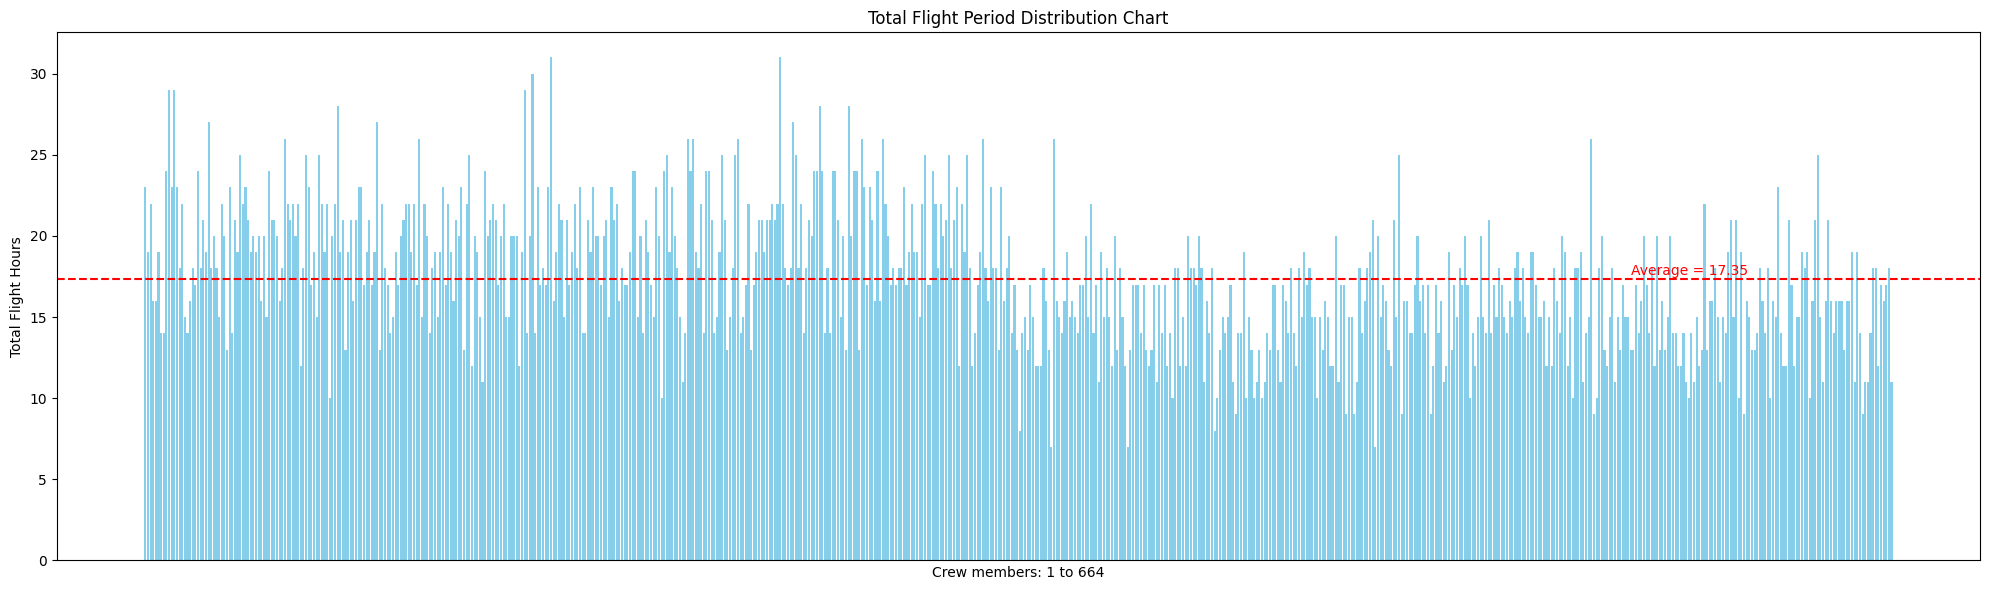

In [19]:
import matplotlib.pyplot as plt


# 提取飞行时间（以小时为单位）
df_result['Flight Hours'] = df_result['总飞行时间'].apply(lambda x: int(x.split('h')[0]))

plt.figure(figsize=(20, 6))
plt.bar(df_result['客舱乘务员编号'], df_result['Flight Hours'], color='skyblue')
plt.title('Total Flight Period Distribution Chart')
plt.xlabel('Crew members: 1 to 664')
plt.ylabel('Total Flight Hours')
plt.xticks([])  # 设置x轴标签为空

avg_value = np.mean(df_result['Flight Hours'])

# 在图中加入表示平均值的线
plt.axhline(avg_value, color='red', linestyle='--', label=f"Average = {avg_value:.2f}")
plt.text(len(data), avg_value + 0.5, f"Average = {avg_value:.2f}", color='red', va='center')


plt.tight_layout()
plt.show()


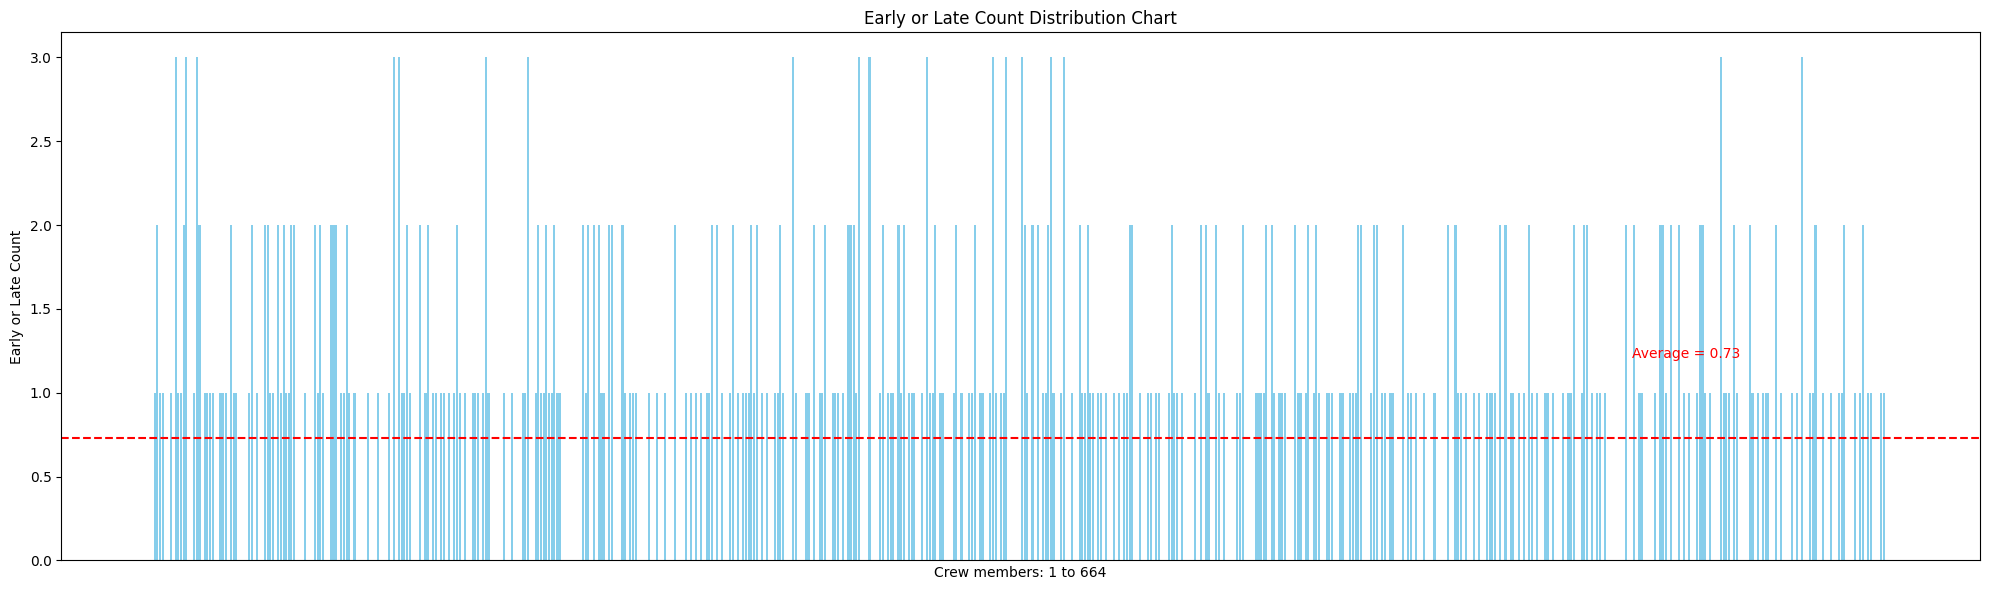

In [20]:
# 提取过早过晚次数
plt.figure(figsize=(20, 6))
plt.bar(df_result['客舱乘务员编号'], df_result['过早过晚航班总次数'], color='skyblue')
plt.title('Early or Late Count Distribution Chart')
plt.xlabel('Crew members: 1 to 664')
plt.ylabel('Early or Late Count')
plt.xticks([])  # 设置x轴标签为空
avg_value = np.mean(df_result['过早过晚航班总次数'])

# 在图中加入表示平均值的线
plt.axhline(avg_value, color='red', linestyle='--', label=f"Average = {avg_value:.2f}")
plt.text(len(data), avg_value + 0.5, f"Average = {avg_value:.2f}", color='red', va='center')


plt.tight_layout()
plt.show()


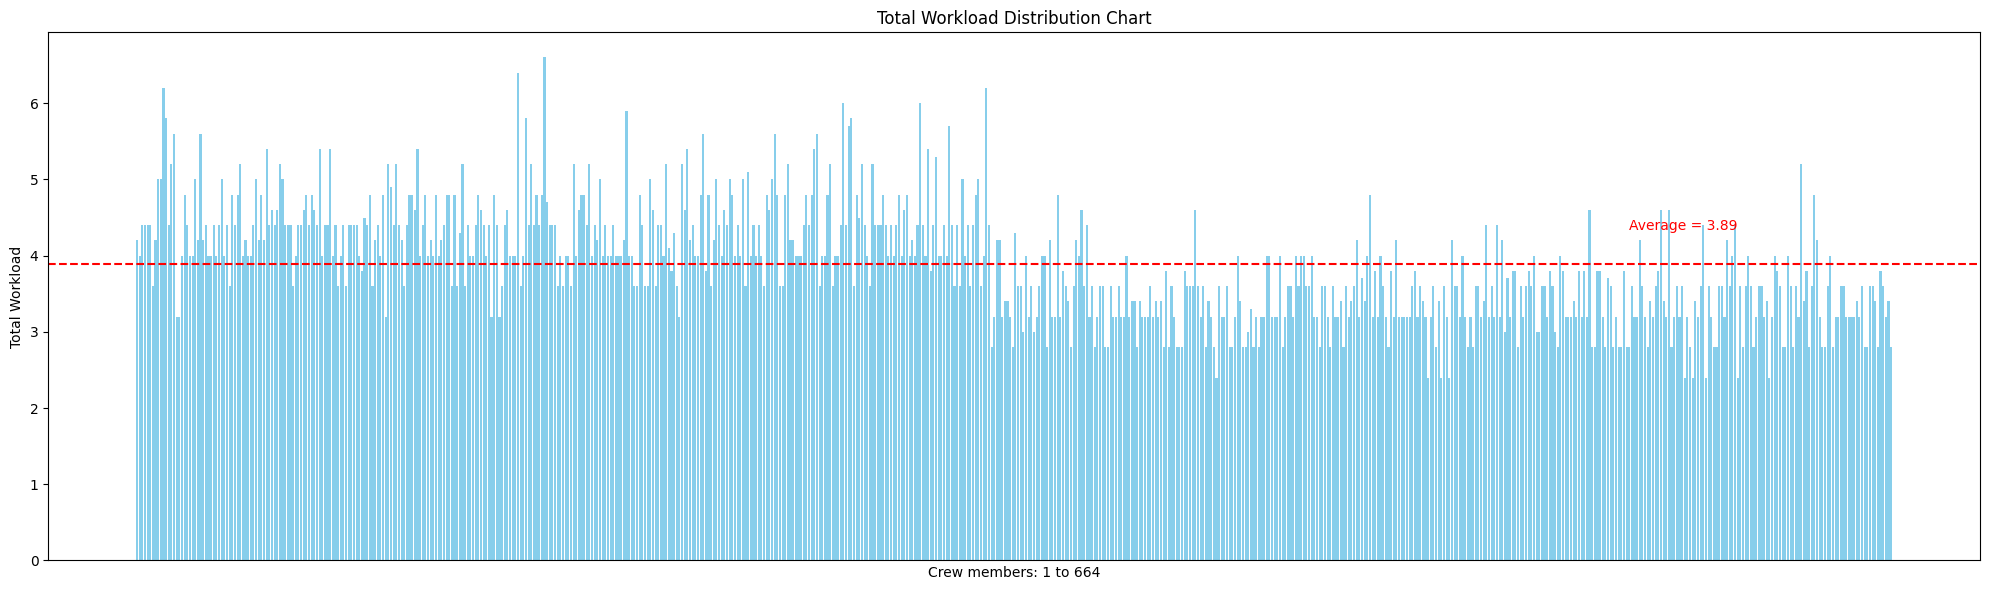

In [21]:
# 提取workload
plt.figure(figsize=(20, 6))
plt.bar(df_result['客舱乘务员编号'], df_result['工作总负荷值'], color='skyblue')
plt.title('Total Workload Distribution Chart')
plt.xlabel('Crew members: 1 to 664')
plt.ylabel('Total Workload')
plt.xticks([])  # 设置x轴标签为空
avg_value = np.mean(df_result['工作总负荷值'])

# 在图中加入表示平均值的线
plt.axhline(avg_value, color='red', linestyle='--', label=f"Average = {avg_value:.2f}")
plt.text(len(data), avg_value + 0.5, f"Average = {avg_value:.2f}", color='red', va='center')


plt.tight_layout()
plt.show()


workload_variance: 0.5454754538516056
Range of Workload: 4.199999999999999
Median Workload: 3.8000000000000003
Max Workload: 6.6
Min Workload: 2.4000000000000004
Workload Balance Ratio: 2.7499999999999996
Average Total Workload: 3.8905120481927713


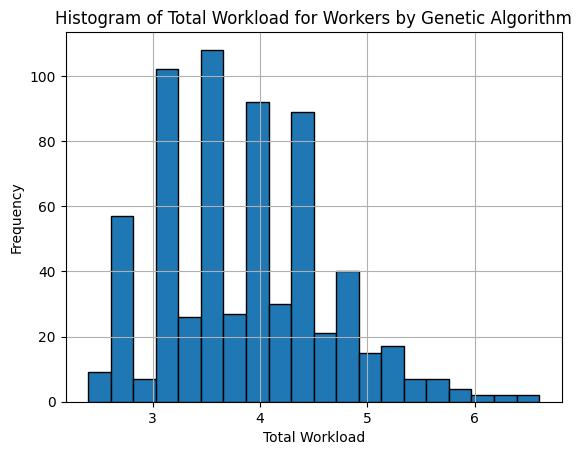

In [22]:
worker_workloads = df_result['工作总负荷值']

workload_variance = worker_workloads.var()

range_workload = np.ptp(worker_workloads)
median_workload = np.median(worker_workloads)
average_total_workload = np.mean(worker_workloads)

# Calculate the workload balance ratio
max_workload = max(worker_workloads)
min_workload = min(worker_workloads)
workload_balance_ratio = max_workload / min_workload

# Display the metrics
print("workload_variance:", workload_variance)
print("Range of Workload:", range_workload)
print("Median Workload:", median_workload)
print("Max Workload:", max_workload)
print("Min Workload:", min_workload)
print("Workload Balance Ratio:", workload_balance_ratio)
print("Average Total Workload:", average_total_workload)


# Plot the histogram of the total workload for workers
plt.hist(worker_workloads, bins=20, edgecolor='black')
plt.xlabel('Total Workload')
plt.ylabel('Frequency')
plt.title('Histogram of Total Workload for Workers by Genetic Algorithm')
plt.grid(True)
plt.show()

In [23]:
cv1 = np.std(worker_workloads) / average_total_workload
cv1

0.1896939876259121

In [24]:
import time

start_time = time.time()  # 获取当前时间


# Extract the workload values and the number of crew members from the 'Workload' and 'Number of Crew Members' columns
workloads = data['Workload'].tolist()
num_crew_members = data['Number of Crew Members'].tolist()

# Define the number of workers and works
num_workers = 664
num_works = len(data)

def assign_works_randomly():
    # Create a list of work indices
    available_works = list(range(num_works))

    # Shuffle the list of work indices to ensure randomness
    random.shuffle(available_works)

    # Create a list to store the work assignments for each worker
    worker_schedule = [[] for _ in range(num_workers)]

    for work in available_works:
        # Find the required number of workers for the current work
        required_workers = num_crew_members[work]

        # Assign the work to available workers one by one
        assigned_workers = 0
        for worker in worker_schedule:
            if assigned_workers < required_workers and not worker:
                worker.append(work)
                assigned_workers += 1

        # If there are still unassigned workers, randomly assign the work to them
        while assigned_workers < required_workers:
            random_worker = random.randrange(num_workers)
            worker_schedule[random_worker].append(work)
            assigned_workers += 1

    return worker_schedule

def calculate_worker_workload(work_schedule):
    worker_workloads = [sum(workloads[work] for work in worker_works) for worker_works in work_schedule]
    return worker_workloads

# Randomly assign works to workers
random_worker_schedule = assign_works_randomly()

# Calculate the total workload for each worker
worker_workloads2 = calculate_worker_workload(random_worker_schedule)

# Create a DataFrame for the random work schedule
random_worker_schedule_df = pd.DataFrame({'Worker': [f'Worker {i+1}' for i in range(num_workers)],
                                          'Works': ['; '.join([f'Work {work+1}' for work in works]) for works in random_worker_schedule],
                                          'Total Workload2': worker_workloads2})




end_time = time.time()  # 获取代码执行完毕后的时间

elapsed_time = end_time - start_time  # 计算两个时间戳之间的差异，得到运行时间

print(f"随机算法运行时间: {elapsed_time:.2f} 秒")
random_worker_schedule_df

随机算法运行时间: 0.01 秒


,Worker,Works,Total Workload2
0,Worker 1,Work 314; Work 41; Work 356,3.6
1,Worker 2,Work 314; Work 350; Work 151; Work 334; Work 244,6.4
2,Worker 3,Work 314; Work 351; Work 106,4.0
3,Worker 4,Work 314; Work 315; Work 145; Work 134,4.4
4,Worker 5,Work 477; Work 528,1.6
...,...,...,...
659,Worker 660,Work 375; Work 160,2.4
660,Worker 661,Work 375,1.2
661,Worker 662,Work 375; Work 511,2.6
662,Worker 663,Work 480; Work 240,2.0


In [25]:
workload_variance2 = random_worker_schedule_df['Total Workload2'].var()
workload_variance2

3.5756306674662457

In [26]:
range_workload2 = np.ptp(worker_workloads2)
range_workload2

10.0

workload_variance2: 3.5756306674662457
Range of Workload2: 10.0
Median Workload2: 3.6000000000000005
Max Workload2: 10.8
Min Workload2: 0.8
Workload Balance Ratio2: 10.8
Average Total Workload2: 3.918072289156627


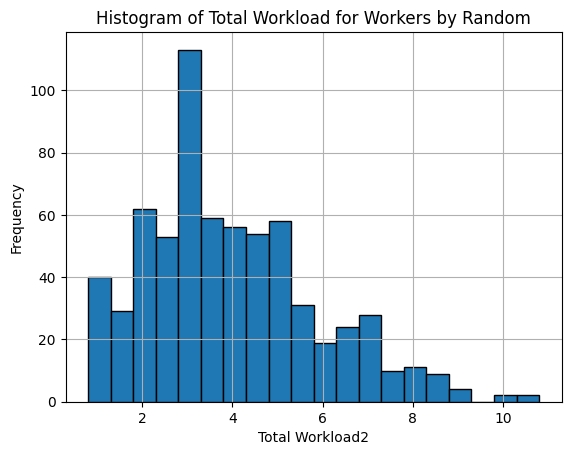

In [27]:
workload_variance2 = random_worker_schedule_df['Total Workload2'].var()
range_workload2 = np.ptp(worker_workloads2)
median_workload2 = np.median(worker_workloads2)
average_total_workload2 = np.mean(worker_workloads2)

# Calculate the workload balance ratio
max_workload2 = max(worker_workloads2)
min_workload2 = min(worker_workloads2)
#workload_balance_ratio2 = max_workload2 / min_workload2
workload_balance_ratio2 = max_workload2 / 1

# Display the metrics
print("workload_variance2:", workload_variance2)
print("Range of Workload2:", range_workload2)
print("Median Workload2:", median_workload2)
print("Max Workload2:", max_workload2)
print("Min Workload2:", min_workload2)
print("Workload Balance Ratio2:", workload_balance_ratio2)
print("Average Total Workload2:", average_total_workload2)


# Plot the histogram of the total workload for workers
plt.hist(random_worker_schedule_df['Total Workload2'], bins=20, edgecolor='black')
plt.xlabel('Total Workload2')
plt.ylabel('Frequency')
plt.title('Histogram of Total Workload for Workers by Random')
plt.grid(True)
plt.show()

In [28]:
cv = np.std(worker_workloads2) / average_total_workload2
cv

0.48225485300634396

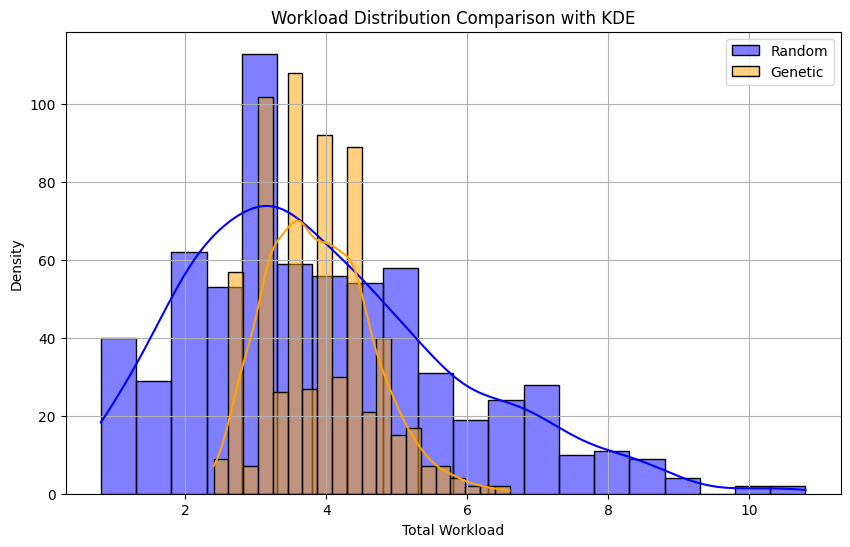

In [29]:
plt.figure(figsize=(10, 6))
sns.histplot(worker_workloads2, kde=True, color='blue', label='Random', alpha=0.5, bins=20)
sns.histplot(worker_workloads, kde=True, color='orange', label='Genetic', alpha=0.5, bins=20)
plt.xlabel('Total Workload')
plt.ylabel('Density')
plt.title('Workload Distribution Comparison with KDE')
plt.legend()
plt.grid(True)
plt.show()

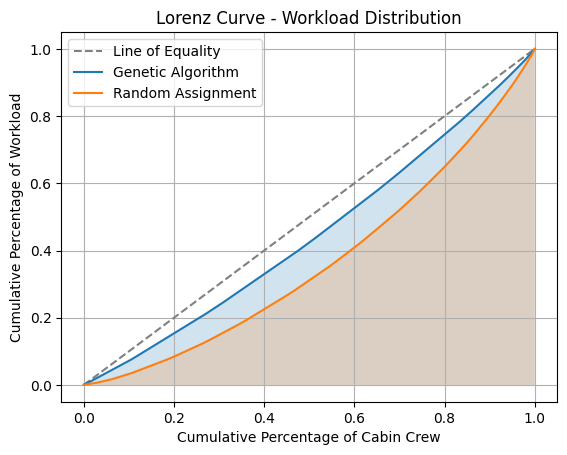

In [30]:


# Assuming you have two lists of total workloads for each person from both methods
# For example:
method1_workloads = worker_workloads # Total workloads for each person in Method 1
method2_workloads = random_worker_schedule_df['Total Workload2']  # Total workloads for each person in Method 2

def calculate_lorenz_curve(workloads):
    sorted_workloads = np.sort(workloads)
    cumulative_workloads = np.cumsum(sorted_workloads)
    cumulative_percentage = cumulative_workloads / np.sum(workloads)
    return cumulative_percentage

# Calculate the Lorenz curves for each method
method1_lorenz = calculate_lorenz_curve(method1_workloads)
method2_lorenz = calculate_lorenz_curve(method2_workloads)

# Plot the Lorenz curves
plt.plot([0, 1], [0, 1], color='gray', linestyle='--', label='Line of Equality')
plt.plot(np.linspace(0, 1, len(method1_lorenz)), method1_lorenz, label='Genetic Algorithm')
plt.plot(np.linspace(0, 1, len(method2_lorenz)), method2_lorenz, label='Random Assignment')
plt.fill_between(np.linspace(0, 1, len(method1_lorenz)), method1_lorenz, alpha=0.2)
plt.fill_between(np.linspace(0, 1, len(method2_lorenz)), method2_lorenz, alpha=0.2)

# Customize the plot
plt.xlabel('Cumulative Percentage of Cabin Crew')
plt.ylabel('Cumulative Percentage of Workload')
plt.title('Lorenz Curve - Workload Distribution')
plt.legend()
plt.grid(True)
plt.show()


In [31]:
# Assuming you have two lists of total workloads for each person from both methods
# For example:
method1_workloads = worker_workloads # Total workloads for each person in Method 1
method2_workloads = random_worker_schedule_df['Total Workload2']  # Total workloads for each person in Method 2

def calculate_percentage_difference(workloads1, workloads2):
    percentage_difference = [(w1 - w2) / w2 * 100 for w1, w2 in zip(workloads1, workloads2)]
    return percentage_difference

# Calculate the percentage difference for each worker's workload between the two methods
percentage_difference = calculate_percentage_difference(method1_workloads, method2_workloads)

# Create a DataFrame to display the results
result_df = pd.DataFrame({'Worker': [f'Worker {i+1}' for i in range(len(method1_workloads))],
                          'Method 1 Workload': method1_workloads,
                          'Method 2 Workload': method2_workloads,
                          'Percentage Difference (%)': np.average(percentage_difference)})

# Display the DataFrame
print(result_df)


         Worker  Method 1 Workload  Method 2 Workload  \
0      Worker 1                4.2                3.6   
1      Worker 2                4.0                6.4   
2      Worker 3                4.4                4.0   
3      Worker 4                4.4                4.4   
4      Worker 5                4.4                1.6   
..          ...                ...                ...   
659  Worker 660                3.8                2.4   
660  Worker 661                3.6                1.2   
661  Worker 662                3.2                2.6   
662  Worker 663                3.4                2.0   
663  Worker 664                2.8                6.0   

     Percentage Difference (%)  
0                    31.327489  
1                    31.327489  
2                    31.327489  
3                    31.327489  
4                    31.327489  
..                         ...  
659                  31.327489  
660                  31.327489  
661               

In [32]:

import scipy.stats as stats

# Assuming you have a list of total workloads for each person
# For example:
workloads = worker_workloads
# Calculate the skewness and kurtosis of the workload distribution
skewness = stats.skew(workloads)
kurtosis = stats.kurtosis(workloads)

# Display the results
print("Genetic Workload Skewness:", skewness)
print("Genetic Workload Kurtosis:", kurtosis)


Genetic Workload Skewness: 0.4903910712370728
Genetic Workload Kurtosis: 0.12321014276166808


In [33]:


# Assuming you have a list of total workloads for each person
# For example:
workloads = random_worker_schedule_df['Total Workload2']

# Calculate the skewness and kurtosis of the workload distribution
skewness = stats.skew(workloads)
kurtosis = stats.kurtosis(workloads)

# Display the results
print("Random Workload Skewness:", skewness)
print("RandomWorkload Kurtosis:", kurtosis)

Random Workload Skewness: 0.7195024927334848
RandomWorkload Kurtosis: 0.2190936126649401


In [34]:
method1_cv = np.std(worker_workloads) / np.mean(worker_workloads)
method2_cv = np.std(worker_workloads2) / np.mean(worker_workloads2)

print("Genetic Coefficient of Variation (CV):", method1_cv)
print("Random Coefficient of Variation (CV):", method2_cv)

Genetic Coefficient of Variation (CV): 0.1896939876259121
Random Coefficient of Variation (CV): 0.48225485300634396
